# Лабораторная работа 3

Выполните классическое и рандомизированное сингулярное разложение одной из цветовых компонент приложенного изображения.
Какое число сингулярных значений требуется для достаточно качественного восстановления изображения?
Как различается время расчета для этих двух видов разложения на вашем компьютере?

### Часть 1. Расчет SVD

In [154]:
import numpy as np
import imageio

im = imageio.imread('tusur.bmp') # считываем изображение из файла в переменную

# Выполняем SVD и выводим время расчета сингулярного разложения для каждого канала
%time ur_svd, sr_svd, vr_svd = np.linalg.svd(im[:, :, 0], full_matrices = 0)
%time ug_svd, sg_svd, vg_svd = np.linalg.svd(im[:, :, 1], full_matrices = 0)
%time ub_svd, sb_svd, vb_svd = np.linalg.svd(im[:, :, 2], full_matrices = 0)

Wall time: 55 ms
Wall time: 44 ms
Wall time: 40 ms


### Часть 2. Восстановление изображения с использованием SVD

In [155]:
im_svd = np.zeros((im[:, :, 0].shape[0], im[:, :, 0].shape[1], 3), int)

rank_svd = 50 # Определение числа учитываемых компонент

# восстанавливаем изображение из rank рассчитанных компонент
im_svd[:, :, 0] = ur_svd[:, : rank_svd] @ np.diag(sr_svd[: rank_svd]) @ vr_svd[: rank_svd, :]
im_svd[:, :, 1] = ug_svd[:, : rank_svd] @ np.diag(sg_svd[: rank_svd]) @ vg_svd[: rank_svd, :]
im_svd[:, :, 2] = ub_svd[:, : rank_svd] @ np.diag(sb_svd[: rank_svd]) @ vb_svd[: rank_svd, :]
im_svd = np.clip(im_svd,0,255)

### Часть 3. Расчет RSVD

In [156]:
def power_iteration(A, Omega, power_iter = 3): # Функция для метода степенных итераций
    Y = A @ Omega                              # Начальное значение матрицы Y считается так же
    for q in range(power_iter):
        Y = A @ (A.T @ Y)                      # С помощью метода степенных итераций значение матрицы Y корректируется
    Q, _ = np.linalg.qr(Y)                     # Матрица Q рассчитывается из Y так же как и раньше
    return Q

def rsvd(A, Omega):                            # Далее расчет не претерпевает изменений, просто теперь в функции rsvd()
    Q = power_iteration(A, Omega)              # вызывается определенная выше функция power_iteration()
    B = Q.T @ A
    u_tilde, s, v = np.linalg.svd(B, full_matrices = 0)
    u = Q @ u_tilde
    return u, s, v

rank_rsvd = 50 # Определение числа учитываемых компонент

omegar = np.random.randn(im[:, :, 0].shape[1], rank_rsvd)
omegag = np.random.randn(im[:, :, 0].shape[1], rank_rsvd)
omegab = np.random.randn(im[:, :, 0].shape[1], rank_rsvd)

%time ur_rsvd, sr_rsvd, vr_rsvd = rsvd(im[:, :, 0], omegar)
%time ug_rsvd, sg_rsvd, vg_rsvd = rsvd(im[:, :, 1], omegag)
%time ub_rsvd, sb_rsvd, vb_rsvd = rsvd(im[:, :, 2], omegab)

Wall time: 9 ms
Wall time: 9 ms
Wall time: 10 ms


### Часть 4. Восстановление изображения с использованием RSVD

In [157]:
im_rsvd = np.zeros((im[:, :, 0].shape[0], im[:, :, 0].shape[1], 3), int)

# восстанавливаем изображение из rank рассчитанных компонент
im_rsvd[:, :, 0] = ur_rsvd[:, : rank_rsvd] @ np.diag(sr_rsvd[: rank_rsvd]) @ vr_rsvd[: rank_rsvd, :]
im_rsvd[:, :, 1] = ug_rsvd[:, : rank_rsvd] @ np.diag(sg_rsvd[: rank_rsvd]) @ vg_rsvd[: rank_rsvd, :]
im_rsvd[:, :, 2] = ub_rsvd[:, : rank_rsvd] @ np.diag(sb_rsvd[: rank_rsvd]) @ vb_rsvd[: rank_rsvd, :]
im_rsvd = np.clip(im_rsvd,0,255)

### Часть 5. Построение изображений

(-0.5, 443.5, 497.5, -0.5)

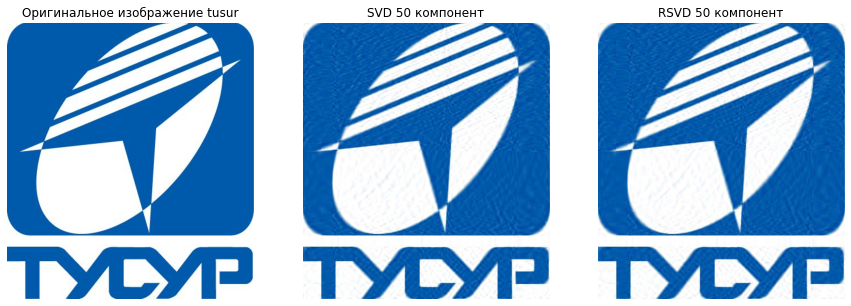

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline


fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15)) # Задаем формат вывода нескольких изображений, 1 строка, 3 колонки
ax1.imshow(im)
ax1.set_title('Оригинальное изображение tusur')
ax1.axis('off') 

ax2.imshow(im_svd)
ax2.set_title('SVD %d компонент'%rank_svd)
ax2.axis('off') 

ax3.imshow(im_rsvd)
ax3.set_title('RSVD %d компонент'%rank_rsvd)
ax3.axis('off') 


### Часть 6. Сравнение изображений

In [159]:
dev_svd = 100*np.sqrt(np.sum(np.square((im - im_svd)/255))/(im.shape[0] * im.shape[1] * im.shape[2]))
dev_rsvd = 100*np.sqrt(np.sum(np.square((im - im_rsvd)/255))/(im.shape[0] * im.shape[1] * im.shape[2]))
print('Среднее СКО точек SVD-изображения от оригинального изображения, составляет: %.2f%%'%dev_svd)
print('Среднее СКО точек RSVD-изображения от оригинального изображения, составляет: %.2f%%'%dev_rsvd)

Среднее СКО точек SVD-изображения от оригинального изображения, составляет: 4.26%
Среднее СКО точек RSVD-изображения от оригинального изображения, составляет: 4.31%


In [160]:
from skimage.metrics import structural_similarity as ssim

print('Индекс структурного сходства SVD-изображения и оригинального изображения составляет: %.2f'
      %ssim(im, im_svd, multichannel=True))
print('Индекс структурного сходства SVD-изображения и оригинального изображения составляет: %.2f'
      %ssim(im, im_rsvd, multichannel=True))


Индекс структурного сходства SVD-изображения и оригинального изображения составляет: 0.75
Индекс структурного сходства SVD-изображения и оригинального изображения составляет: 0.74
